# Unzip Image Dataset

In [1]:
!unzip dataset-1000.zip

Archive:  dataset-1000.zip
   creating: dataset/
   creating: dataset/product-review/
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/product-main/
  inflating: dataset/product-review/buku-7-3.png  
  inflating: dataset/product-review/kosmetik-29-1.png  
  inflating: dataset/product-review/makan-27-0.png  
  inflating: dataset/product-review/tas-12-1.png  
  inflating: dataset/product-review/tas-2-0.png  
  inflating: dataset/product-review/buku-24-0.png  
  inflating: dataset/product-review/perabot-8-0.png  
  inflating: dataset/product-review/sepatu-28-1.png  
  inflating: dataset/product-review/elektronik-12-2.png  
  inflating: dataset/product-review/mainan-2-3.png  
  inflating: dataset/product-review/buku-5-1.png  
  inflating: dataset/product-review/makan-25-2.png  
  inflating: dataset/product-review/tas-0-2.png  
  inflating: dataset/product-review/tas-10-3.png  
  inflating: dataset/product-review/buku-26-2.png  
  inflat

# Install Dependencies

In [9]:
!pip install catboost -q
!pip install fasttext -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Import Dependencies

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
from PIL import Image
import io
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import fasttext
from huggingface_hub import hf_hub_download
import pickle

2025-07-10 09:45:12.255749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752140712.508991      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752140712.618233      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [11]:
dataset_raw = pd.read_csv('multilang_dataset.csv')

In [12]:
dataset_raw.head()

,product-main,product-review,caption,label
0,baju-0.png,baju-0-0.png,Halo kak! Aku mau jualan baju online murah mer...,0
1,baju-0.png,baju-0-1.png,PROMO GILA!! Baju branded original hanya 50rb!...,0
2,baju-0.png,baju-0-2.png,Saya mau refund baju hitam ini. Barang yang di...,1
3,baju-0.png,baju-0-3.png,Mohon refund segera. Baju yang dikirim berbeda...,1
4,baju-1.png,baju-1-0.png,DISKON AKHIR TAHUN! Semua baju cuma 25rb! Kual...,0


In [13]:
# Function to load image data
def load_image(row, name):
    image_path = os.path.join('dataset', name, row[name])
    with open(image_path, 'rb') as f:
        # Read the image file content
        image_data = f.read()
        return image_data

dataset = dataset_raw.copy()
dataset['img-prod-main'] = dataset_raw.apply(load_image, axis=1, name='product-main')
dataset['img-prod-review'] = dataset_raw.apply(load_image, axis=1, name='product-review')

dataset.head()

,product-main,product-review,caption,label,img-prod-main,img-prod-review
0,baju-0.png,baju-0-0.png,Halo kak! Aku mau jualan baju online murah mer...,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,baju-0.png,baju-0-1.png,PROMO GILA!! Baju branded original hanya 50rb!...,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,baju-0.png,baju-0-2.png,Saya mau refund baju hitam ini. Barang yang di...,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,baju-0.png,baju-0-3.png,Mohon refund segera. Baju yang dikirim berbeda...,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,baju-1.png,baju-1-0.png,DISKON AKHIR TAHUN! Semua baju cuma 25rb! Kual...,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [6]:
dataset_img = dataset[['img-prod-main','img-prod-review']]
dataset_cap = dataset[['caption']]

In [7]:
dataset_cap.head()

,caption
0,Halo kak! Aku mau jualan baju online murah mer...
1,PROMO GILA!! Baju branded original hanya 50rb!...
2,Saya mau refund baju hitam ini. Barang yang di...
3,Mohon refund segera. Baju yang dikirim berbeda...
4,DISKON AKHIR TAHUN! Semua baju cuma 25rb! Kual...


In [8]:
dataset_img.head()

,img-prod-main,img-prod-review
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


# Feature Engineering

## Embedding Image Features

### Embedding Function

In [9]:
def bytes_to_image(image_bytes):
    try:
        return Image.open(io.BytesIO(image_bytes)).convert("RGB")
    except Exception as e:
        return None

# Batching function
@torch.no_grad()
def get_batch_embeddings(images, model_name):
    if model_name == 'dino':
        inputs = processor_dino(images=images, return_tensors="pt", padding=True).to(device)
        outputs = model_dino(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # shape: (batch_size, 1024)
    elif model_name == 'vit':
        inputs = processor_vit(images=images, return_tensors="pt", padding=True).to(device)
        outputs = model_vit(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # shape: (batch_size, 1024)
    elif model_name == 'resnet':
        inputs = processor_resnet(images=images, return_tensors="pt", padding=True).to(device)
        outputs = model_resnet(**inputs)
        # Apply mean pooling to ResNet output
        return outputs.last_hidden_state.mean(dim=[2, 3]).cpu().numpy() # shape: (batch_size, 1024)

In [10]:
def extract_embeddings_from_column(df, column_name, model_name,batch_size=32):
    embeddings = []
    batch = []

    for image_data in tqdm(df[column_name], desc=f"Processing {column_name}"):
        image = bytes_to_image(image_data)
        if image:
            batch.append(image)
        else:
            embeddings.append(None)
            continue

        # Kalau sudah cukup batch
        if len(batch) == batch_size:
            batch_features = get_batch_embeddings(batch, model_name)
            embeddings.extend(batch_features)
            batch = []

    # Sisa batch terakhir
    if batch:
        batch_features = get_batch_embeddings(batch, model_name)
        embeddings.extend(batch_features)

    return embeddings

### Transfomer

#### DINOv2-Large

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor_dino = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
model_dino = AutoModel.from_pretrained("facebook/dinov2-large").to(device)
model_dino.eval()

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((1024,),

In [12]:
# Terapkan ke dataframe
dataset_dino = dataset_img.copy()
dataset_dino['img-prod-main-features'] = extract_embeddings_from_column(dataset_dino, 'img-prod-main', model_name='dino')
dataset_dino['img-prod-review-features'] = extract_embeddings_from_column(dataset_dino, 'img-prod-review',model_name='dino')

Processing img-prod-main:   1%|▏         | 16/1080 [00:00<00:06, 159.80it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `BitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Processing img-prod-review:   0%|          | 0/1080 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `BitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Processing img-prod-review: 100%|██████████| 1080/1080 [00:56<00:00, 19.26it/s]


#### ViT-L/16

In [13]:
processor_vit = AutoImageProcessor.from_pretrained("google/vit-large-patch16-224")
model_vit = AutoModel.from_pretrained("google/vit-large-patch16-224").to(device)
model_vit.eval()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-23): 24 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=1024, out_features=4096, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
  

In [14]:
# Terapkan ke dataframe
dataset_vit = dataset_img.copy()
dataset_vit['img-prod-main-features'] = extract_embeddings_from_column(dataset_vit, 'img-prod-main', model_name='vit')
dataset_vit['img-prod-review-features'] = extract_embeddings_from_column(dataset_vit, 'img-prod-review', model_name='vit')


Processing img-prod-main:   0%|          | 0/1080 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)

Processing img-prod-review:   0%|          | 0/1080 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Processing img-prod-review: 100%|██████████| 1080/1080 [00:44<00:00, 24.41it/s]


### Konvensional

#### ResNet 101

In [15]:
processor_resnet = AutoImageProcessor.from_pretrained("microsoft/resnet-101")
model_resnet = AutoModel.from_pretrained("microsoft/resnet-101").to(device)
model_resnet.eval()

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

In [16]:
# Terapkan ke dataframe
dataset_resnet = dataset_img.copy()
dataset_resnet['img-prod-main-features'] = extract_embeddings_from_column(dataset_resnet, 'img-prod-main', model_name='resnet')
dataset_resnet['img-prod-review-features'] = extract_embeddings_from_column(dataset_resnet, 'img-prod-review', model_name='resnet')

Processing img-prod-main:   0%|          | 0/1080 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `ConvNextImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Processing img-prod-main:   3%|▎         | 32/1080 [00:00<00:17, 60.33it/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Processing img-prod-review:   0%|          | 0/1080 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `ConvNextImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Processing img-prod-review: 100%|██████████| 1080/1080 [00:14<00:00, 76.97it/s]


## Embedding Text Features

### Embedding Function

In [17]:
@torch.no_grad()
def embed_batch(texts, model_name, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding captions"):
        batch = texts[i:i + batch_size]
        # Tambahkan prefix "query: " sesuai instruksi E5
        batch = [f"query: {text}" for text in batch]
        if model_name == 'e5':
            tokenizer = tokenizer_e5
            model = model_e5
        elif model_name == 'qwen':
            tokenizer = tokenizer_qwen
            model = model_qwen
        elif model_name == 'jina':
            tokenizer = tokenizer_jina
            model = model_jina

        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
        output = model(**tokens)
        # Mean pooling
        attention_mask = tokens['attention_mask']
        last_hidden_state = output.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        summed = torch.sum(last_hidden_state * mask_expanded, 1)
        counts = torch.clamp(mask_expanded.sum(1), min=1e-9)
        mean_pooled = summed / counts
        embeddings.append(mean_pooled.cpu())
    return torch.cat(embeddings, dim=0)

### Transformer

#### Mutilingual-E5-Large

In [18]:
model_name = "intfloat/multilingual-e5-large"
tokenizer_e5 = AutoTokenizer.from_pretrained(model_name)
model_e5 = AutoModel.from_pretrained(model_name).to(device)
model_e5.eval()

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, eleme

In [19]:
dataset_e5 = dataset_cap.copy()
captions = dataset_e5["caption"].astype(str).tolist()
caption_embeddings_e5 = embed_batch(captions, 'e5', batch_size=32)

dataset_e5["caption_embeddings"] = list(caption_embeddings_e5.numpy())

Embedding captions: 100%|██████████| 34/34 [00:07<00:00,  4.83it/s]


#### Qwen-Embedding-06B

In [20]:
model_name = "Qwen/Qwen3-Embedding-0.6B"
tokenizer_qwen = AutoTokenizer.from_pretrained(model_name)
model_qwen = AutoModel.from_pretrained(model_name).to(device)
model_qwen.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

Qwen3Model(
  (embed_tokens): Embedding(151669, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

In [21]:
dataset_qwen = dataset_cap.copy()
captions = dataset_qwen["caption"].astype(str).tolist()
caption_embeddings_qwen = embed_batch(captions, 'qwen', batch_size=32)

dataset_qwen["caption_embeddings"] = list(caption_embeddings_qwen.numpy())

Embedding captions: 100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


#### Jina v3

In [22]:
model_name = "jinaai/jina-embeddings-v3"
tokenizer_jina = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model_jina = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
model_jina.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_xlm_roberta.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py: 0.00B [00:00, ?B/s]

modeling_xlm_roberta.py: 0.00B [00:00, ?B/s]

xlm_padding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py: 0.00B [00:00, ?B/s]

rotary.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py: 0.00B [00:00, ?B/s]

mlp.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


stochastic_depth.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- mlp.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- xlm_padding.py
- mha.py
- block.py
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

XLMRobertaLoRA(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): ParametrizedEmbedding(
        250002, 1024, padding_idx=1
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): LoRAParametrization()
          )
        )
      )
      (token_type_embeddings): ParametrizedEmbedding(
        1, 1024
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): LoRAParametrization()
          )
        )
      )
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
    (emb_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): XLMRobertaEncoder(
      (layers): ModuleList(
        (0-23): 24 x Block(
          (mixer): MHA(
            (rotary_emb): RotaryEmbedding()
            (Wqkv): ParametrizedLinearResidual(
              in_features=1024, out_features=3072, bias=True
              (parametrizations): ModuleDict(
                (weight): 

In [23]:
dataset_jina = dataset_cap.copy()
captions = dataset_jina["caption"].astype(str).tolist()
caption_embeddings_jina = embed_batch(captions, 'jina', batch_size=32)

dataset_jina["caption_embeddings"] = list(caption_embeddings_jina.numpy())

Embedding captions: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


#### FastText

In [24]:
model_fasttext = fasttext.load_model(hf_hub_download(repo_id="facebook/fasttext-id-vectors", filename="model.bin"))

model.bin:   0%|          | 0.00/7.24G [00:00<?, ?B/s]

In [25]:
dataset_fasttext = dataset_cap.copy()

captions = dataset_fasttext["caption"].astype(str).tolist()

def embed_batch_fasttext(captions):
    embeddings = []
    for text in tqdm(captions):
        vec = model_fasttext.get_sentence_vector(text)
        embeddings.append(vec)
    return np.vstack(embeddings)

caption_embeddings_fasttext = embed_batch_fasttext(captions)
dataset_fasttext["caption_embeddings"] = list(caption_embeddings_fasttext)

100%|██████████| 1080/1080 [00:00<00:00, 16613.42it/s]


## Image Only Features

In [50]:
dataset_embed_img_only = {}

# Only process the 'dino' image dataset
for img_name, dataset_img in [("dino", dataset_dino)]:
    #convert menjadi matrix
    img_main_matrix = np.stack(dataset_img['img-prod-main-features'])
    img_review_matrix = np.stack(dataset_img['img-prod-review-features'])

    #numpy row menjadi column
    df_img_main_embed = pd.DataFrame(img_main_matrix, columns=[f"img_main_{i}" for i in range(img_main_matrix.shape[1])])
    df_img_review_embed = pd.DataFrame(img_review_matrix, columns=[f"img_review_{i}" for i in range(img_review_matrix.shape[1])])
    label = pd.DataFrame(dataset['label'])

    #concat
    combine_dataset = pd.concat([df_img_main_embed, df_img_review_embed, label], axis=1)
    dataset_embed_img_only[f'{img_name}_only'] = combine_dataset

## Text Only Features

In [51]:
dataset_embed_text_only = {}
for text_name, dataset_text in [("qwen", dataset_qwen)]:
    # convert menjadi matrix
    text_matrix = np.stack(dataset_text['caption_embeddings'])
    # numpy row menjadi column
    df_text_embed = pd.DataFrame(text_matrix, columns=[f"text_{i}" for i in range(text_matrix.shape[1])])
    label = pd.DataFrame(dataset['label'])

    # concat
    combine_dataset = pd.concat([df_text_embed, label], axis=1)
    dataset_embed_text_only[f'{text_name}_only'] = combine_dataset

## Combine All Features

In [48]:
dataset_embed = {}

# list dataset
list_dataset_img = [("dino", dataset_dino), ("vit", dataset_vit), ("resnet", dataset_resnet)]
list_dataset_cap = [("e5", dataset_e5), ("qwen", dataset_qwen), ("jina", dataset_jina), ("fasttext", dataset_fasttext)]

for img_name, dataset_img in list_dataset_img:
  for cap_name, dataset_cap in list_dataset_cap:
    #convert menjadi matrix
    img_main_matrix = np.stack(dataset_img['img-prod-main-features'])
    img_review_matrix = np.stack(dataset_img['img-prod-review-features'])
    text_matrix = np.stack(dataset_cap['caption_embeddings'])
    #numpy row menjadi column
    df_img_main_embed = pd.DataFrame(img_main_matrix, columns=[f"img_main_{i}" for i in range(img_main_matrix.shape[1])])
    df_img_review_embed = pd.DataFrame(img_review_matrix, columns=[f"img_review_{i}" for i in range(img_review_matrix.shape[1])])
    df_text_embed = pd.DataFrame(text_matrix, columns=[f"text_feat_{i}" for i in range(text_matrix.shape[1])])
    label = pd.DataFrame(dataset['label'])
    #concat
    combine_dataset = pd.concat([df_img_main_embed,df_img_review_embed,df_text_embed,label],axis=1)
    dataset_embed[f'{img_name} x {cap_name}'] = combine_dataset

## PCA 3 Component

Memuat gambar dari
Mengekstrak fitur patch dari layer terakhir model
Menerapkan PCA pada 256 patch
Membuat gambar overlay RGB dari komponen utama


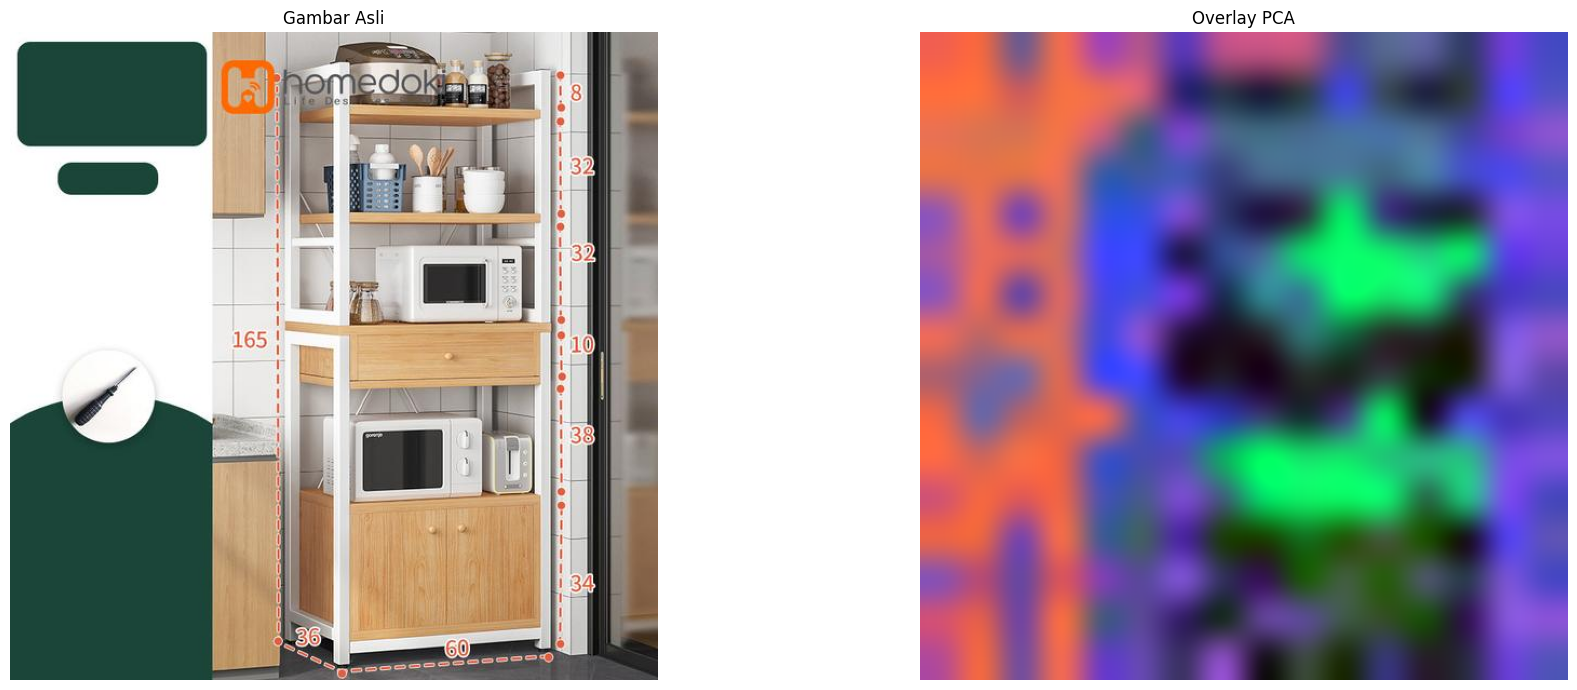

Memuat gambar dari
Mengekstrak fitur patch dari layer terakhir model
Menerapkan PCA pada 256 patch
Membuat gambar overlay RGB dari komponen utama


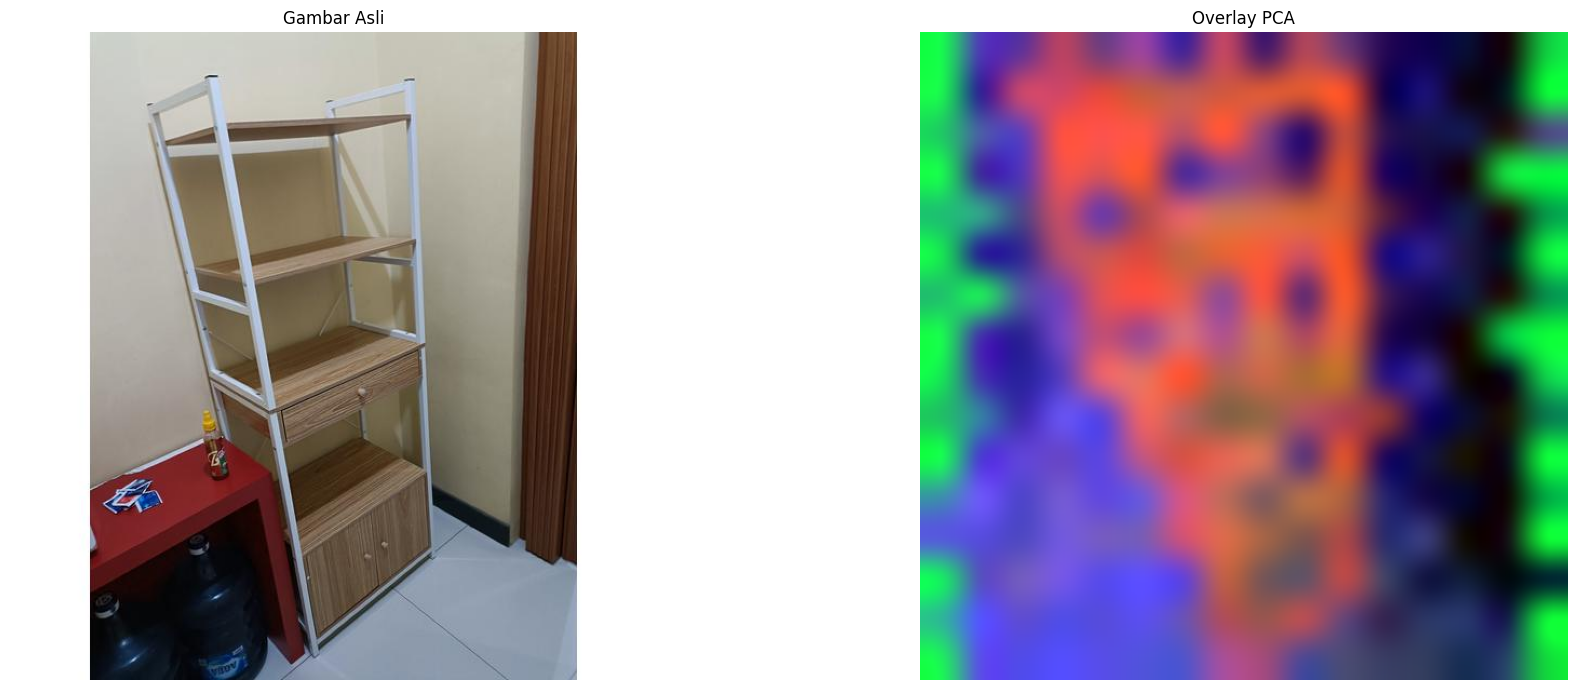

In [91]:
def create_attention_visualization(image_path_or_url):

    print(f"Memuat gambar dari")
    try:
        image = Image.open(image_path_or_url).convert('RGB')
    except Exception as e:
        print(f"Error: Tidak dapat memuat gambar. {e}")
        return

    original_size = image.size
    inputs = processor_dino(images=image, return_tensors="pt").to(device)

    print("Mengekstrak fitur patch dari layer terakhir model")
    with torch.no_grad():
        # Kita ingin output dari layer encoder terakhir, sebelum di-pool menjadi satu vektor
        outputs = model_dino(**inputs, output_hidden_states=True)
        # Ambil hidden state dari layer terakhir. Shape: (batch, sequence_length, hidden_dim)
        last_hidden_state = outputs.hidden_states[-1]
        # Hapus token [CLS] di awal (token pertama)
        patch_features = last_hidden_state[:, 1:, :].squeeze(0).cpu().numpy()

    print(f"Menerapkan PCA pada {patch_features.shape[0]} patch")
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(patch_features)

    # BUAT GAMBAR OVERLAY DARI HASIL PCA
    print("Membuat gambar overlay RGB dari komponen utama")
    # Normalisasi setiap komponen ke rentang [0, 1] untuk dijadikan channel warna
    pc_normalized = np.zeros_like(principal_components)
    for i in range(3):
        pc_i = principal_components[:, i]
        pc_normalized[:, i] = (pc_i - pc_i.min()) / (pc_i.max() - pc_i.min())

    # Susun kembali patch berwarna menjadi sebuah gambar
    patch_grid_size = int(np.sqrt(principal_components.shape[0]))
    rgb_overlay_array = pc_normalized.reshape(patch_grid_size, patch_grid_size, 3)

    # Ubah ukuran gambar overlay agar sama dengan gambar asli
    overlay_image = Image.fromarray((rgb_overlay_array * 255).astype(np.uint8))
    overlay_image_resized = overlay_image.resize(original_size, Image.BICUBIC)

    # visualisasia
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs[0].imshow(image)
    axs[0].set_title('Gambar Asli')
    axs[0].axis('off')

    axs[1].imshow(overlay_image_resized)
    axs[1].set_title('Overlay PCA')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Untuk product-main
IMAGE_TO_ANALYZE = "dataset/perabot-11.png"

create_attention_visualization(IMAGE_TO_ANALYZE)

# Untuk product-review
IMAGE_TO_ANALYZE = "dataset/perabot-11-1.png"

create_attention_visualization(IMAGE_TO_ANALYZE)

# Modeling

## Combine Text and Image

### Catboost

In [61]:
for name, data in dataset_embed.items():
    # Split training data
    X = data.drop('label', axis=1)
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y
    )

    # Train model
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        eval_metric='Accuracy',
        random_seed=42,
        verbose=10
    )
    model.fit(X_train, y_train, verbose=False)

    # TEST SET

    y_pred_test = model.predict(X_test)
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]

    acc_test = accuracy_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test_proba)
    f1_test = f1_score(y_test, y_pred_test)

    print(f"\n{name} - TEST")
    print(f"Accuracy : {acc_test:.4f}")
    print(f"ROC AUC  : {roc_test:.4f}")
    print(f"F1 Score : {f1_test:.4f}")


dino x e5 - TEST
Accuracy : 0.8333
ROC AUC  : 0.9249
F1 Score : 0.8435

dino x qwen - TEST
Accuracy : 0.8843
ROC AUC  : 0.9420
F1 Score : 0.8899

dino x jina - TEST
Accuracy : 0.8241
ROC AUC  : 0.9009
F1 Score : 0.8376

dino x fasttext - TEST
Accuracy : 0.8657
ROC AUC  : 0.9232
F1 Score : 0.8700

vit x e5 - TEST
Accuracy : 0.8287
ROC AUC  : 0.9164
F1 Score : 0.8426

vit x qwen - TEST
Accuracy : 0.8657
ROC AUC  : 0.9420
F1 Score : 0.8722

vit x jina - TEST
Accuracy : 0.8009
ROC AUC  : 0.8821
F1 Score : 0.8139

vit x fasttext - TEST
Accuracy : 0.8148
ROC AUC  : 0.9194
F1 Score : 0.8182

resnet x e5 - TEST
Accuracy : 0.8148
ROC AUC  : 0.9159
F1 Score : 0.8319

resnet x qwen - TEST
Accuracy : 0.8611
ROC AUC  : 0.9428
F1 Score : 0.8673

resnet x jina - TEST
Accuracy : 0.8333
ROC AUC  : 0.9084
F1 Score : 0.8407

resnet x fasttext - TEST
Accuracy : 0.8657
ROC AUC  : 0.9340
F1 Score : 0.8700


### XGBoost

In [53]:
for name, data in dataset_embed.items():
  # Split training data
  X = data.drop('label', axis=1)
  y = data['label']
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=5, stratify=y
  )

  # Train model
  model = XGBClassifier(n_estimators=100,
                      learning_rate=0.1,
                      max_depth=6,
                      objective='binary:logistic',
                      random_state=42)
  model.fit(X_train, y_train,verbose=False)

  # TEST SET
  y_pred_test = model.predict(X_test)
  y_pred_test_proba = model.predict_proba(X_test)[:, 1]

  acc_test = accuracy_score(y_test, y_pred_test)
  roc_test = roc_auc_score(y_test, y_pred_test_proba)
  f1_test = f1_score(y_test, y_pred_test)

  print(f"\n{name} - TEST")
  print(f"Accuracy : {acc_test:.4f}")
  print(f"ROC AUC  : {roc_test:.4f}")
  print(f"F1 Score : {f1_test:.4f}")


dino x e5 - TEST
Accuracy : 0.8194
ROC AUC  : 0.9128
F1 Score : 0.8267

dino x qwen - TEST
Accuracy : 0.8750
ROC AUC  : 0.9453
F1 Score : 0.8811

dino x jina - TEST
Accuracy : 0.8009
ROC AUC  : 0.8990
F1 Score : 0.8170

dino x fasttext - TEST
Accuracy : 0.8333
ROC AUC  : 0.9158
F1 Score : 0.8393

vit x e5 - TEST
Accuracy : 0.8426
ROC AUC  : 0.9166
F1 Score : 0.8509

vit x qwen - TEST
Accuracy : 0.8889
ROC AUC  : 0.9442
F1 Score : 0.8947

vit x jina - TEST
Accuracy : 0.7963
ROC AUC  : 0.8936
F1 Score : 0.8120

vit x fasttext - TEST
Accuracy : 0.8519
ROC AUC  : 0.9156
F1 Score : 0.8584

resnet x e5 - TEST
Accuracy : 0.8287
ROC AUC  : 0.9149
F1 Score : 0.8412

resnet x qwen - TEST
Accuracy : 0.8981
ROC AUC  : 0.9517
F1 Score : 0.9027

resnet x jina - TEST
Accuracy : 0.7963
ROC AUC  : 0.8967
F1 Score : 0.8103

resnet x fasttext - TEST
Accuracy : 0.8380
ROC AUC  : 0.9068
F1 Score : 0.8444


## Only Image

In [62]:
for name, data in dataset_embed_img_only.items():
    # Split training data
    X = data.drop('label', axis=1)
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y
    )

    # Train model
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        eval_metric='Accuracy',
        random_seed=42,
        verbose=10
    )
    model.fit(X_train, y_train, verbose=False)

    # TEST SET
    y_pred_test = model.predict(X_test)
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]

    acc_test = accuracy_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test_proba)
    f1_test = f1_score(y_test, y_pred_test)

    print(f"\n{name} - TEST")
    print(f"Accuracy : {acc_test:.4f}")
    print(f"ROC AUC  : {roc_test:.4f}")
    print(f"F1 Score : {f1_test:.4f}")


dino_only - TEST
Accuracy : 0.4676
ROC AUC  : 0.4569
F1 Score : 0.4700


## Only Text

In [77]:
for name, data in dataset_embed_text_only.items():
    # Split training data
    X = data.drop('label', axis=1)
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y
    )
    
    # Train model
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        eval_metric='Accuracy',
        random_seed=42,
        verbose=10
    )
    model.fit(X_train, y_train, verbose=False)
    
    # TEST SET
    y_pred_test = model.predict(X_test)
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]

    acc_test = accuracy_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test_proba)
    f1_test = f1_score(y_test, y_pred_test)

    print(f"\n{name} - TEST")
    print(f"Accuracy : {acc_test:.4f}")
    print(f"ROC AUC  : {roc_test:.4f}")
    print(f"F1 Score : {f1_test:.4f}")



qwen_only - TEST
Accuracy : 0.8796
ROC AUC  : 0.9364
F1 Score : 0.8829


## Save Best Model

In [34]:
best_data = dataset_embed['dino x qwen']
X = best_data.drop('label', axis=1)
y = best_data['label']

best_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=0
)

best_model.fit(X, y) # Train full dataset

# Simpan model menggunakan pickle
model_filename = 'best_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)